### Time Series Workshop 
# 5. Online Retail: Forecasting Challenge Sample Solution

Eh, this is a sample solution for the previous challenge. 

You were'nt supposed to see this. I didn't think anybody would open a notebook with the most uninteresting file name imaginable. Ah, whatever. &#x1F937;

In [1]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from feature_engine.creation import CyclicalFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer as ftrf

from timeseries.data import load_retail
from timeseries.utils import print_metrics
from timeseries import preprocessing as pp

DATA_DIR = Path("..") / Path("data")

## Load data

In [2]:
TARGET_COL = "sales"
SPLIT_DATE = "2011-09-30"
FILE_PATH = DATA_DIR / "online_retail.csv"

df_in = load_retail(FILE_PATH)
df_in.head()

,sales
month,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


## Analyze data

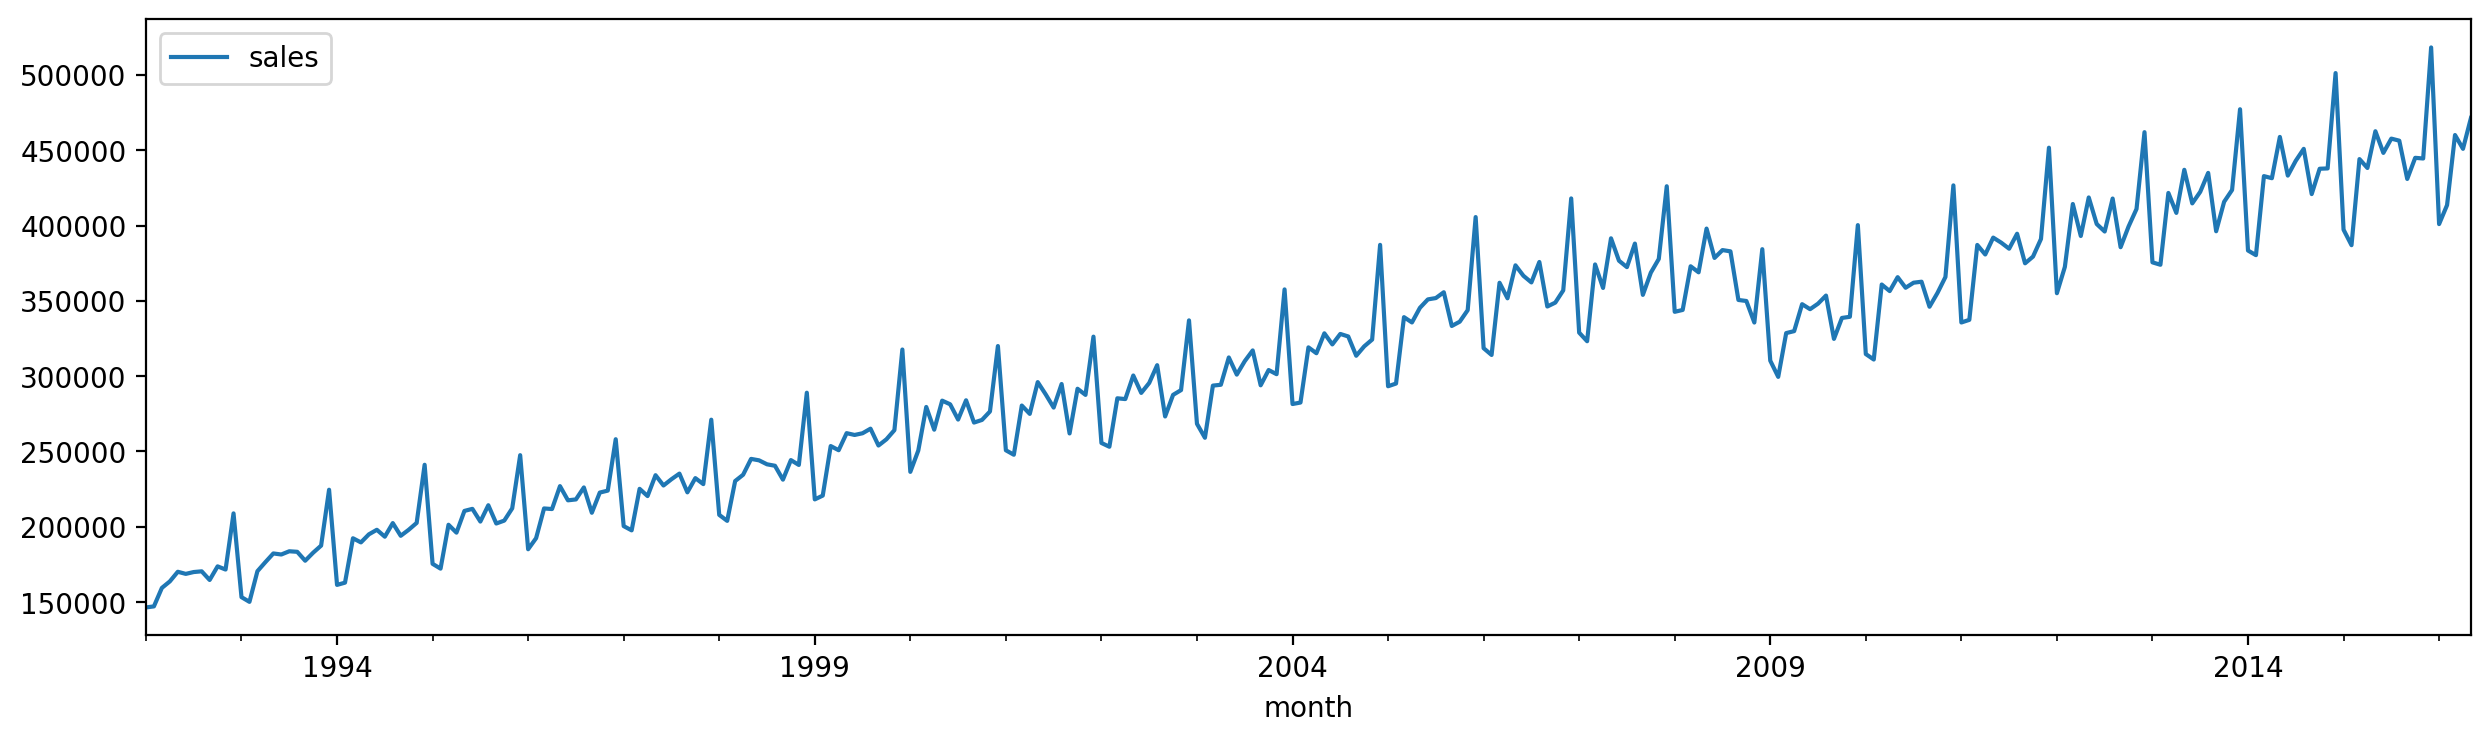

In [3]:
df = df_in.copy()

_ = df.plot(figsize=[15, 4])

- Looks pretty benign, no missing values 
- Yearly seasonality pattern clearly visible!
- Strong trend upwards!
- The econmoic crisis in 2008 is clearly visible in the data as a cusp

 # Seasonality

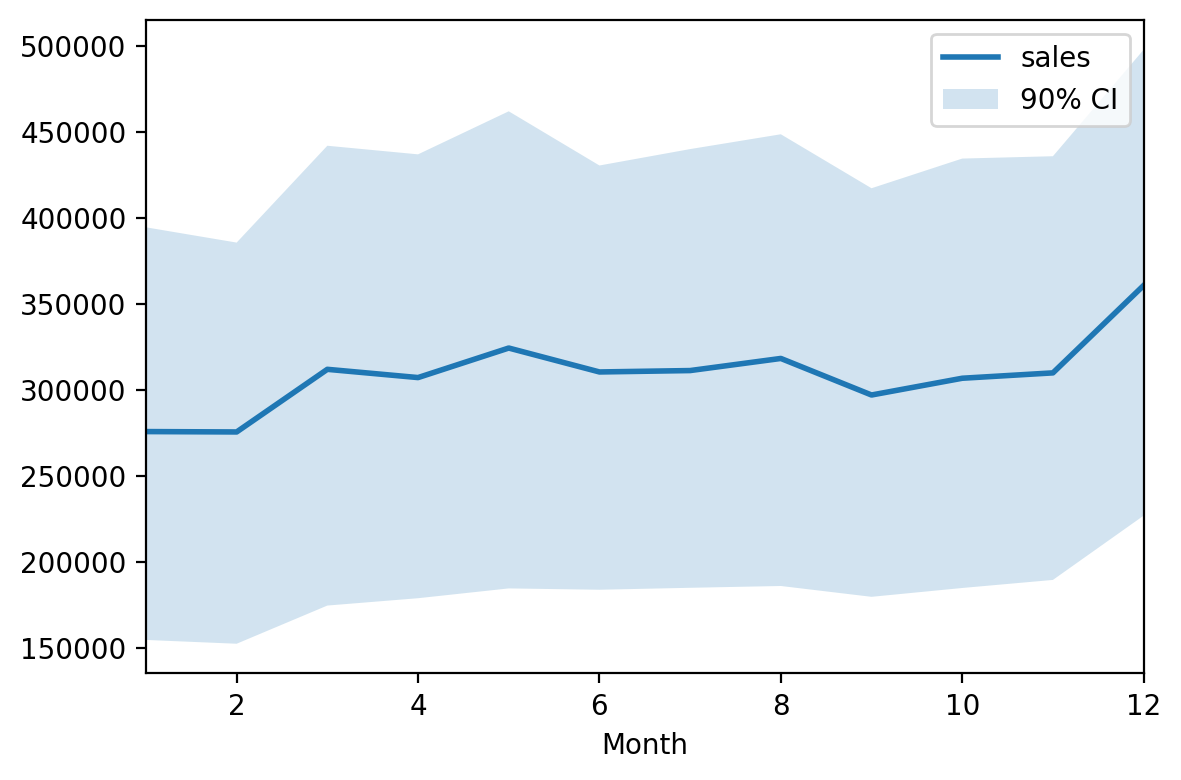

In [4]:
def q05(x):
    return x.quantile(0.05)


def q95(x):
    return x.quantile(0.95)


_, ax = plt.subplots(figsize=(6, 4))
df_season = df[[TARGET_COL]].copy()

# Group by hour of the day and compute mean and 90% confidence interval
df_season["m"] = df_season.index.month
df_time_season = df_season.groupby("m")[[TARGET_COL]].agg(["mean", q05, q95])

# Plot mean values
ax.plot(df_time_season[TARGET_COL]["mean"], label=TARGET_COL, linewidth=2)

# Plot confidence intervals
ax.fill_between(
    df_time_season.index,
    df_time_season[TARGET_COL]["q05"],
    df_time_season[TARGET_COL]["q95"],
    alpha=0.2,
    label="90% CI",
)

ax.set_xlabel("Month")
ax.set_xlim((1, 12))
ax.legend()
plt.tight_layout()

- Seasonality analysis by grouping data is not helpful here, due to the strong trend!
- We can use the `seasonal_decompose` function from `statsmodels` to decompose the time series into trend, seasonality and residuals

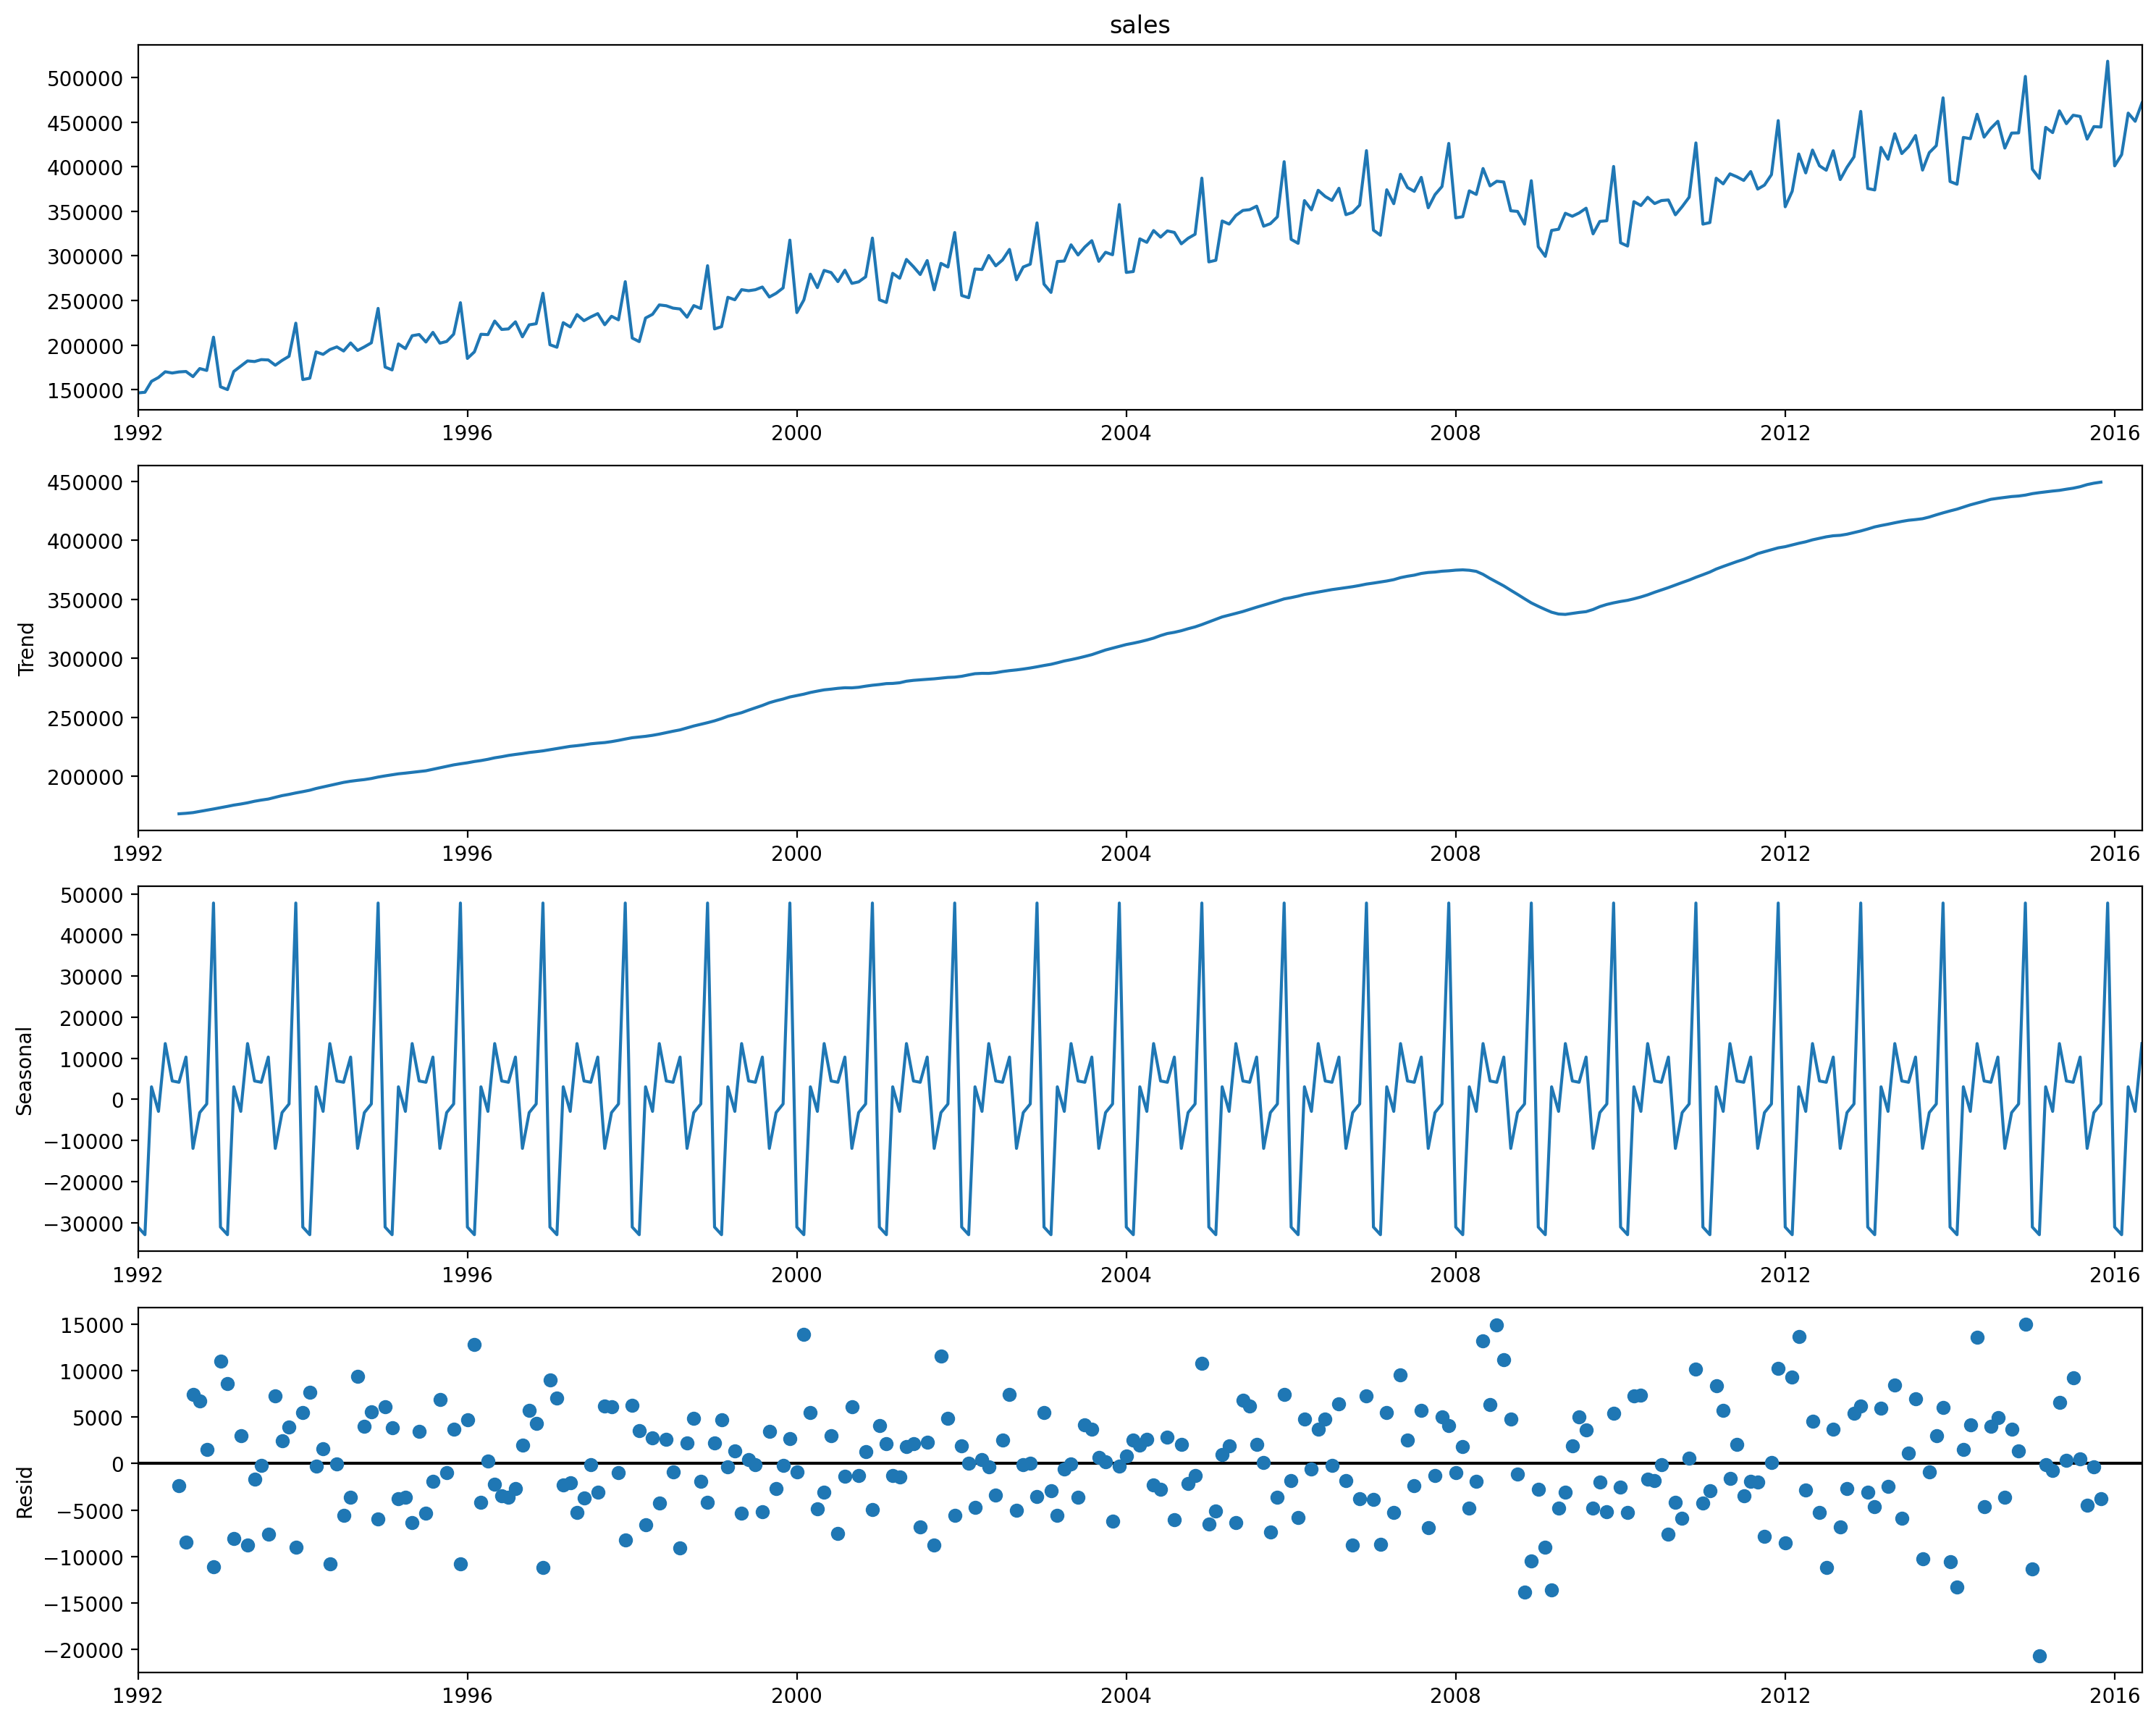

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df[TARGET_COL], model='additive')
fig = result.plot()
_ = fig.set_size_inches(15, 12)
_ = plt.tight_layout()

Looks good to me! 
- Strong trend
- Yearly seasonality
- Residuals are pretty random, but with a slight upwards trend

I'll build a simple model out of this!

## Build instructive model

### 1. Train-test split
- Before using the seasonality pattern and trend we got form the decomposition, we need to split off the test set as to not fall prey to look-ahead bias

In [6]:
df_train = df.loc[df.index < SPLIT_DATE].copy()
df_test = df.loc[df.index >= SPLIT_DATE].copy()

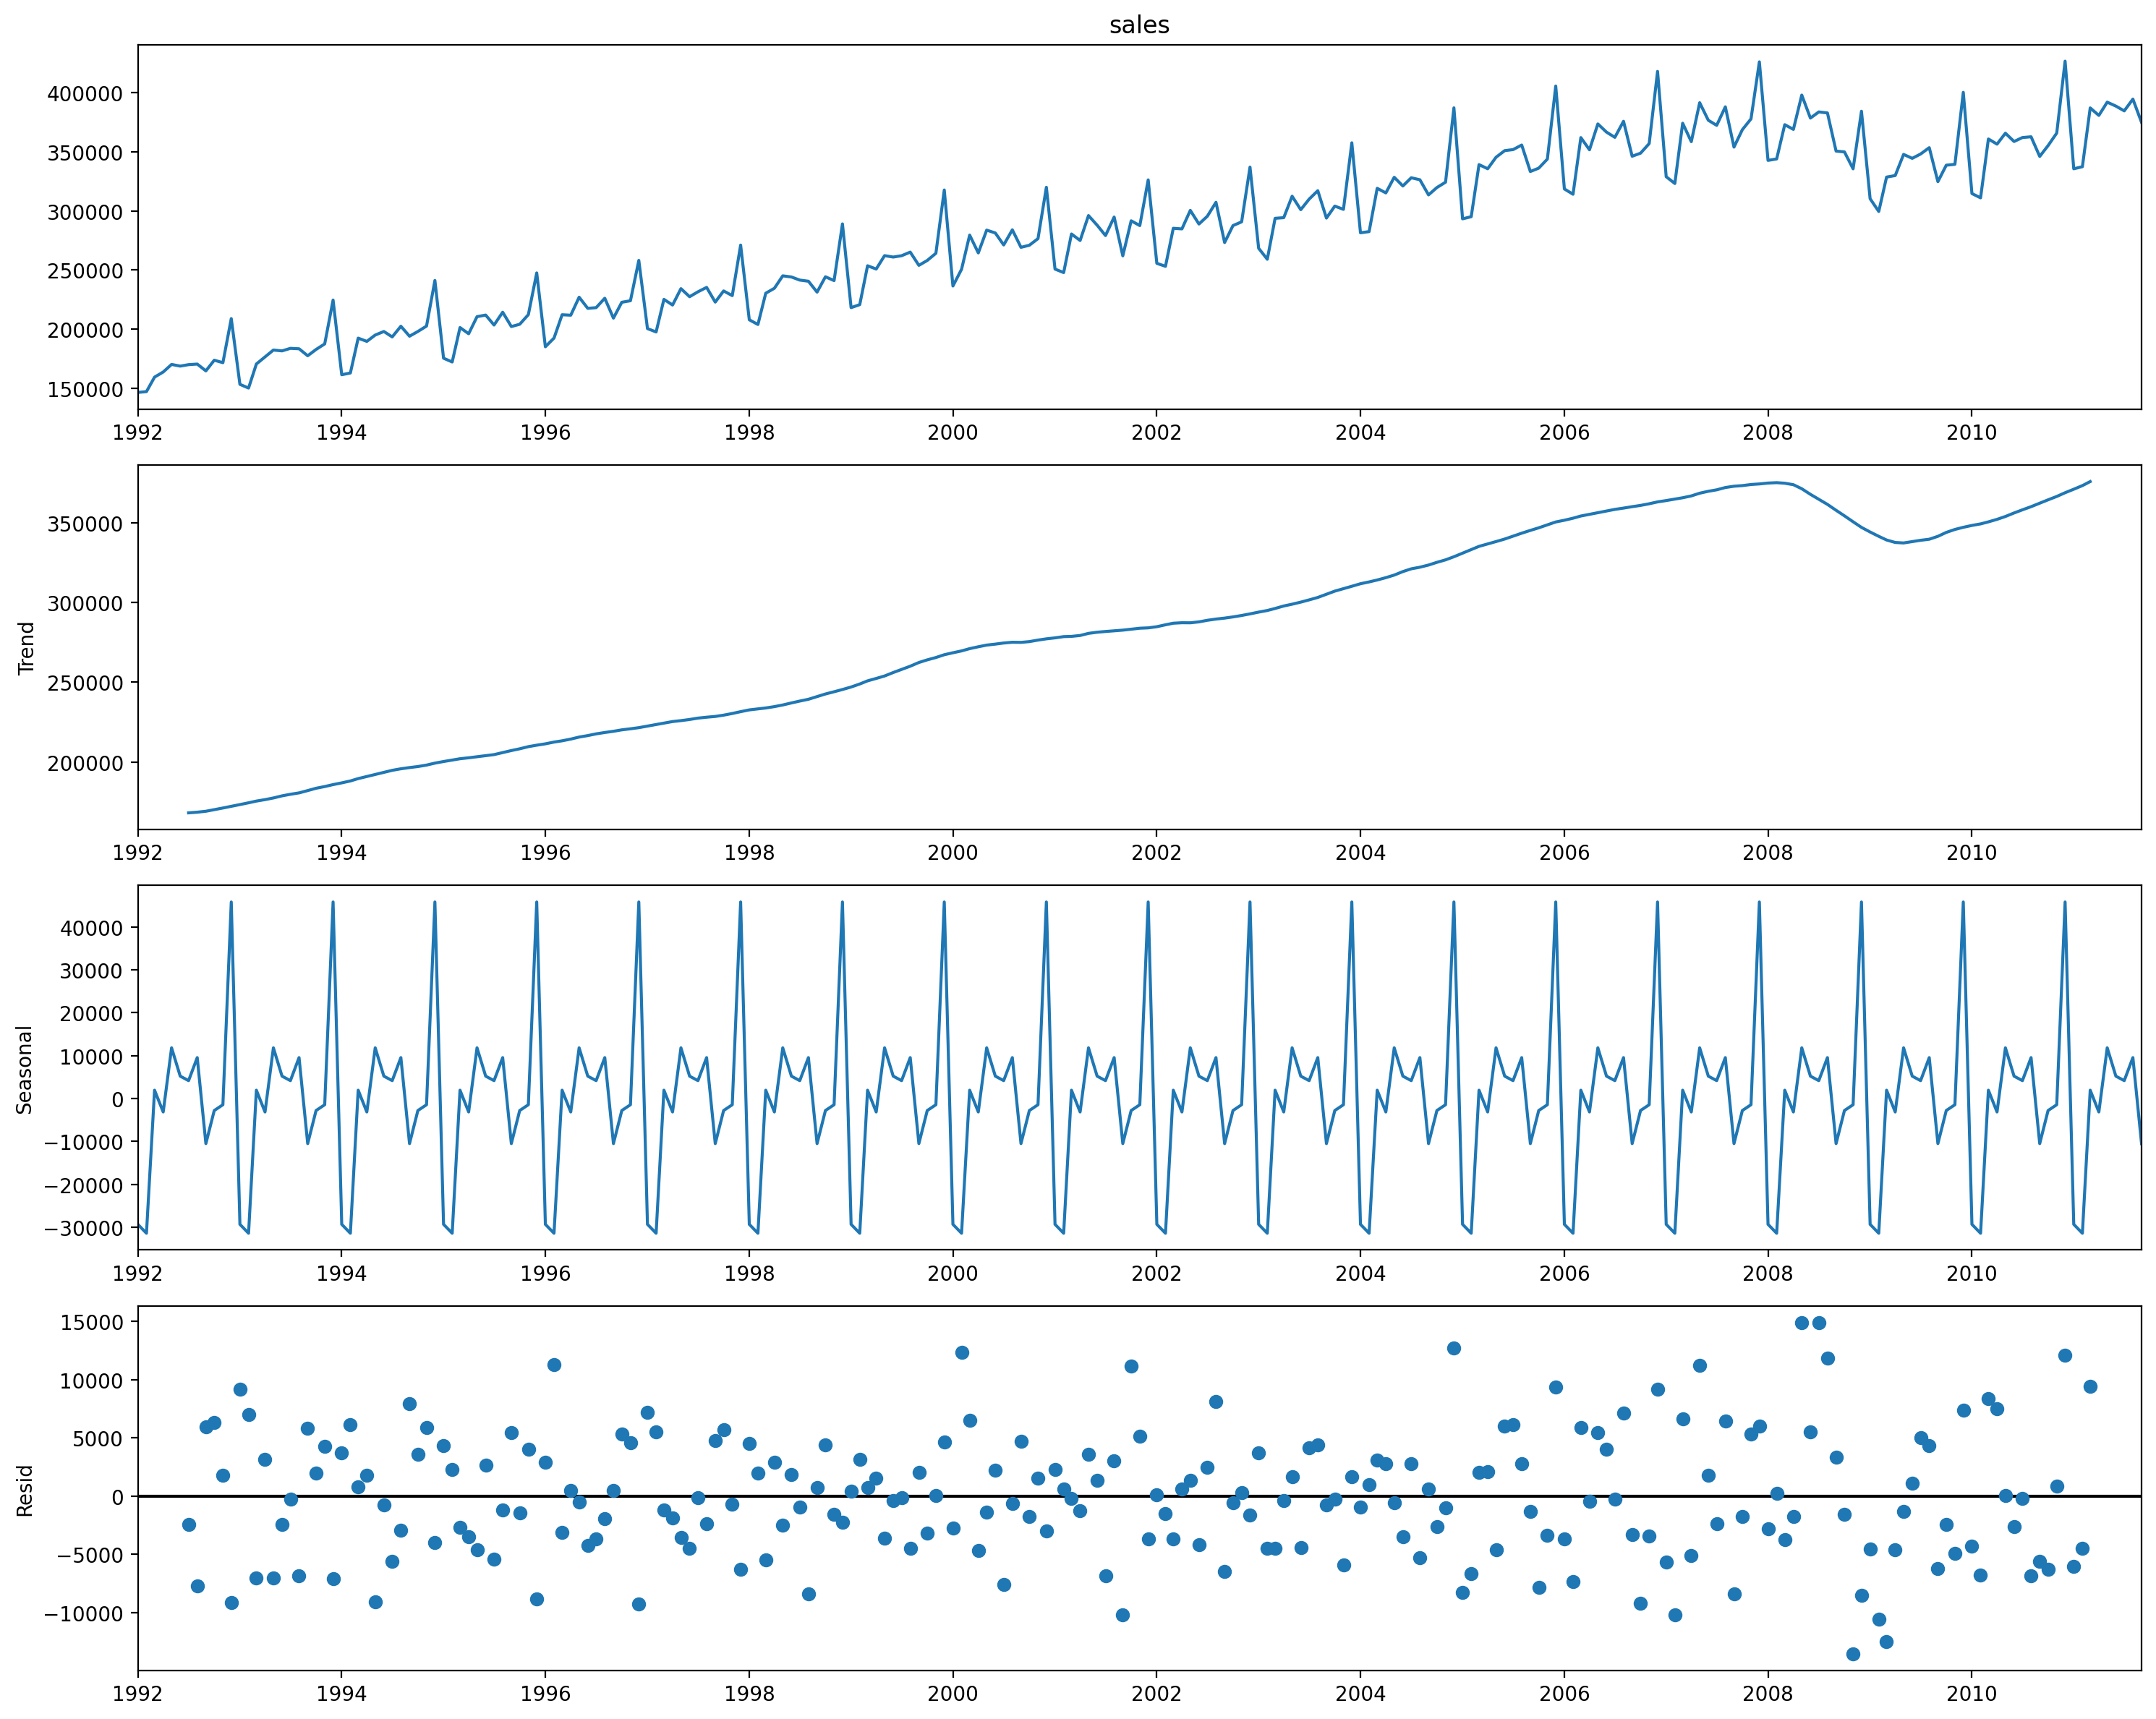

In [7]:
result = seasonal_decompose(df_train[TARGET_COL], model='additive')
fig = result.plot()
_ = fig.set_size_inches(15, 12)
_ = plt.tight_layout()

- If we now only take the slope of the trend and the seasonality pattern, we might already get a pretty good forecast
- Let's extract the seasonality first

Note: This is super manual stuff that's mainly meant to be instructive. In a real-world scenario, one would probably use a more sophisticated/easy to deal with model.

{1: -29298.968435266397,
 2: -31378.87633000325,
 3: 1946.9877050844693,
 4: -3124.123527858994,
 5: 11821.425083252112,
 6: 5221.0963795484,
 7: 4179.031564733588,
 8: 9545.889020873947,
 9: -10490.630715968147,
 10: -2784.475014213773,
 11: -1437.3236984243067,
 12: 45799.96796824236}

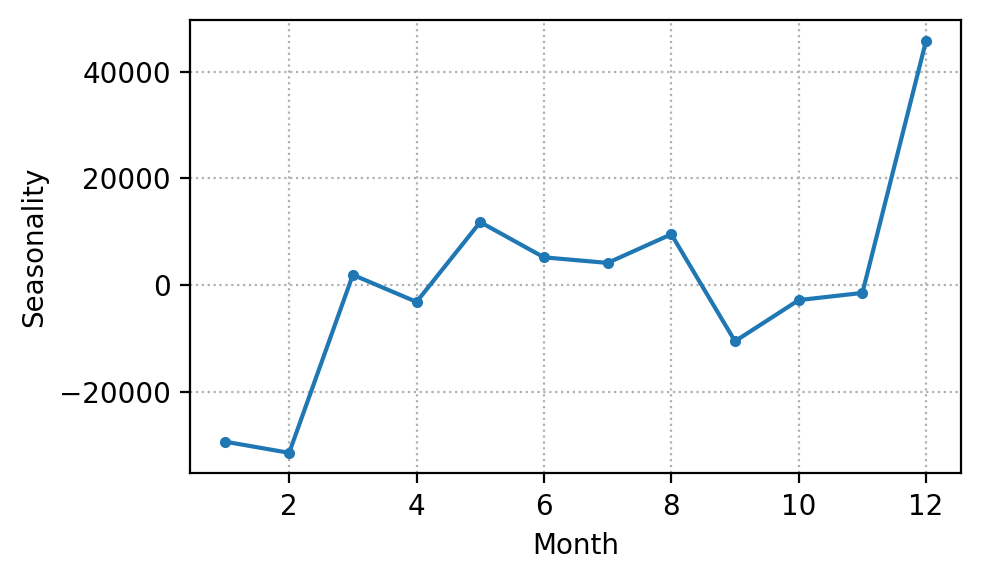

In [8]:
df_season = pd.DataFrame(result.seasonal)
seasonality = df_season.groupby(df_season.index.month)["seasonal"].mean().to_dict()

_ , ax = plt.subplots(figsize=(5, 3))
_ = ax.plot(seasonality.keys(), seasonality.values(), marker=".")
_ = ax.set_xlabel("Month")
_ = ax.set_ylabel("Seasonality")
_ = ax.grid(linestyle=":")
_ = plt.tight_layout()
seasonality

## The Cheat: Facebook Prophet!
What's that? You ask. &#x1F914; Let's find out with ChatGPT!

**Prompt:** 

Hi ChatGPT, can you write me a short markdown text explaining how Facebook prophet works? And please use some LaTeX expressions!

**Response:**

Certainly! Facebook Prophet is a time series forecasting model that decomposes the data into several components, including a trend component, a seasonal component, and a residual component. The additive composition of these components can be expressed as:

\begin{equation}
y(t) = g(t) + s(t) + h(t) + \epsilon_t
\end{equation}

where:

- $y(t)$ is the observed time series at time $t$
- $g(t)$ is the trend component, which models the non-periodic changes in the time series over time
- $s(t)$ is the seasonal component, which models the periodic changes in the time series over time
- $h(t)$ is the holiday component, which models the effects of holidays and other events that occur irregularly over time
- $\epsilon_t$ is the residual component, which represents the random fluctuations in the time series that are not explained by the other components.



In [9]:

df_prophet = df.reset_index().rename(columns={"month":"ds", "sales":"y"})
df_prophet.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from prophet import Prophet

df_train = df_prophet.loc[df_prophet.ds < SPLIT_DATE].copy()
df_test = df_prophet.loc[df_prophet.ds >= SPLIT_DATE].copy()

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

10:22:08 - cmdstanpy - INFO - Chain [1] start processing
10:22:08 - cmdstanpy - INFO - Chain [1] done processing
10:22:08 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
10:22:08 - cmdstanpy - INFO - Chain [1] start processing
10:22:08 - cmdstanpy - INFO - Chain [1] done processing
10:22:08 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/malte.weinberg/Library/Caches/pypoetry/virtualenvs/timeseries-ApTM6bFP-py3.9/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin random seed=95371 data file=/var/folders/4s/3bxn70s57z161fbjd7p3x0w4l4dgpm/T/tmpub7qba5s/qir8z79_.json init=/var/folders/4s/3bxn70s57z161fbjd7p3x0w4l4dgpm/T/tmpub7qba5s/on31luac.json output file=/var/folders/4s/3bxn70s57z161fbjd7p3x0w4l4dgpm/T/tmpub7qba5s/prophet_modelj614bkbe/prophet_model-20230505102208.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[38299]: Library not loaded: '@rpath/libtbb.dylib'
  Referenced from: '/Users/malte.weinberg/Library/Caches/pypoetry/virtualenvs/timeseries-ApTM6bFP-py3.9/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin'
  Reason: tried: '/private/var/folders/4s/3bxn70s57z161fbjd7p3x0w4l4dgpm/T/pip-req-build-a80aya40/build/lib.macosx-12.5-arm64-cpython-39/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/4s/3bxn70s57z161fbjd7p3x0w4l4dgpm/T/pip-req-build-a80aya40/build/lib.macosx-12.5-arm64-cpython-39/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file)


Why is this cheating? Because if you take a look at the data source URL it turns out to be a toy example from exactly this package... that necessarily performs really well.

In [ ]:

dfs

month
1    -29298.968435
2    -31378.876330
3      1946.987705
4     -3124.123528
5     11821.425083
6      5221.096380
7      4179.031565
8      9545.889021
9    -10490.630716
10    -2784.475014
11    -1437.323698
12    45799.967968
Name: seasonal, dtype: float64

KeyError: 'seasonal'

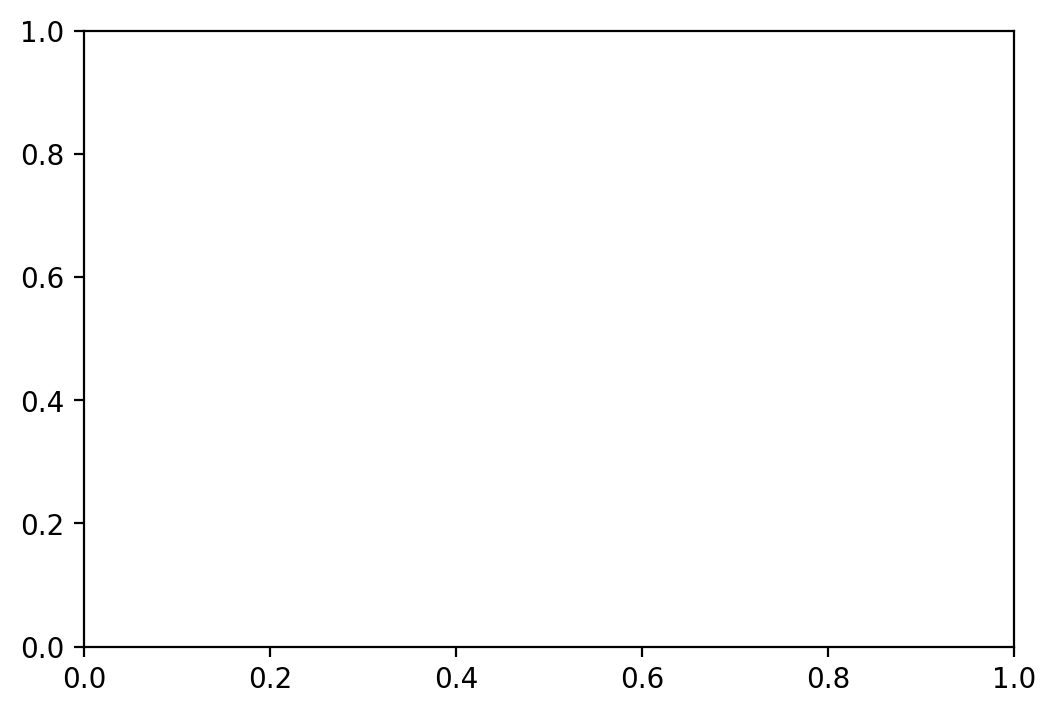

In [ ]:
df_season = pd.DataFrame(result.seasonal)
df_season["m"] = df_season.index.month
df_season = df_season.groupby("m")["seasonal"].mean()
_, ax = plt.subplots(figsize=(6, 4))

# Plot mean values
ax.plot(df_season["seasonal"]["mean"], label="seasonality", linewidth=2)
ax.set_xlabel("Month of the year")
ax.set_xlim((1, 12))
ax.legend()
plt.tight_layout()

In [ ]:
i

## Feature engineering

Ellipsis

## Train-test split
- Split the data into train- and test sets according to the SPLIT_DATE parameter defined above


In [ ]:
...

Ellipsis

## Build models and forecast!
- Fit the processed training data 
- Predict for the test set
- Calculate the usual metrics
  - How good is your forecast? Compare a naive baseline model with something more sophisticated.
  - What metric is the most appropriate here?
  - Can you manage to beat my own forecast? (We will have a little competition here) &#x1F6A8;

Good luck!

In [ ]:
...

Ellipsis